# 훈련 데이터셋에 대한 군집화 (K-Means)


In [96]:
# 필수 라이브러리 로드 및 설정
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_score

sns.set_theme(style="whitegrid", palette="crest")

In [97]:
# plt.rcParams["font.family"] = "Malgun Gothic"
# plt.rcParams["axes.unicode_minus"] = False

In [98]:
# WSL2 font setting
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False) # 마이너스 기호 깨짐 방지

In [99]:
def find_project_root(start: Path) -> Path:
    # 상위 폴더로 거슬러 올라가 .git 디렉터리가 있는 경로를 찾습니다.
    for candidate in [start, *start.parents]:
        if (candidate / ".git").is_dir():
            return candidate
    raise FileNotFoundError(".git 폴더를 찾을 수 없습니다. 프로젝트 루트를 확인하세요.")

PROJECT_ROOT = find_project_root(Path.cwd())
# DATA_PATH = PROJECT_ROOT / "data/training/final/travel_ml.csv"
# DATA_PATH = PROJECT_ROOT / "data/training/final/travel_insight.csv"
DATA_PATH = PROJECT_ROOT / "data/training/final/travel_insight_pruned.csv"


In [100]:
travel = pd.read_csv(DATA_PATH)
travel = travel.drop(columns='TRAVEL_ID', axis=1)

In [101]:
# 학습에 사용할 피처값 선언
# BINARY_CLASSIFICATION_TARGET = 'IS_FAILED_TRIP'

CLUSTERING_FEATURES = [
    'TRIP_DAYS',
    'MOVE_CNT',
    'activity_payment_sum',
    'activity_history_rows',
    'ACTIVITY_TYPE_CD',
    'move_cnt_per_day',
    'activity_payment_sum_per_day',
    'activity_history_rows_per_day',
    # 'payment_persona'
]

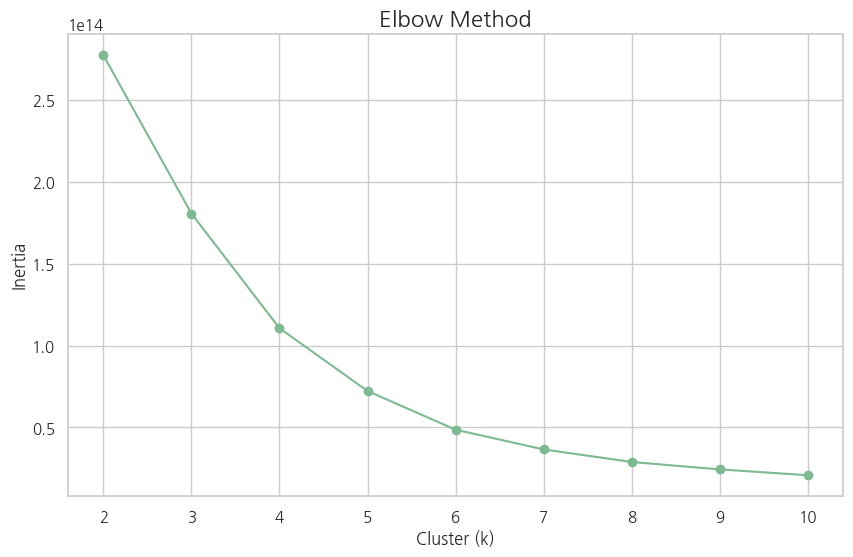

In [102]:
# Elbow method
from sklearn.cluster import KMeans

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X=travel[CLUSTERING_FEATURES])
    # kmeans.fit(X=travel)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method', fontsize=16)
plt.xlabel('Cluster (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

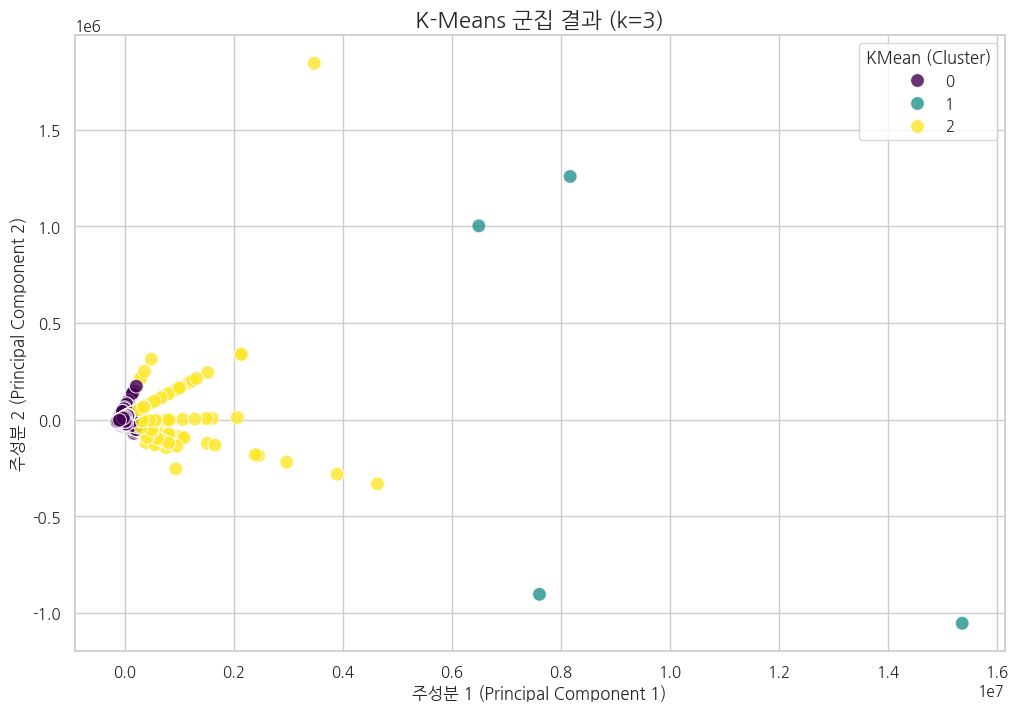

In [103]:
# PCA
from sklearn.decomposition import PCA

# Elbow 결과 기반 k 선택 예시 (여기서는 k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X=travel[CLUSTERING_FEATURES])
# cluster_labels = kmeans.fit_predict(X=travel)

travel['KMEANS_CLUSTER'] = cluster_labels

pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(X=travel[CLUSTERING_FEATURES])
# cluster_pca = pca.fit_transform(X=travel)

pca_df = pd.DataFrame(data=cluster_pca, columns=['PC1', 'PC2'])
pca_df['CLUSTER'] = cluster_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='CLUSTER', data=pca_df, palette='viridis', s=100, alpha=0.8)
plt.title(f"K-Means 군집 결과 (k={optimal_k})", fontsize=16)
plt.xlabel("주성분 1 (Principal Component 1)", fontsize=12)
plt.ylabel("주성분 2 (Principal Component 2)", fontsize=12)
plt.legend(title='KMean (Cluster)')
plt.grid(True)
plt.show()

In [104]:
# 실루엣 스코어 출력 (PCA 시각화와 별개)
sil_score = silhouette_score(
    X=pca_df[['PC1', 'PC2']],
    labels=travel['KMEANS_CLUSTER']
)
sil_score

0.7885823243216123

In [105]:
# numeric_features = [
#     'activity_payment_sum', 'activity_payment_count', 'activity_store_count',
#     'activity_history_rows', 'activity_type_unique', 'lodging_payment_sum',
#     'lodging_payment_count', 'lodging_store_count', 'visit_trip_days',
#     'visit_move_cnt', 'AGE_GRP', 'FAMILY_MEMB', 'INCOME',
#     'HOUSE_INCOME', 'TRAVEL_TERM', 'TRAVEL_NUM', 'TRAVEL_COMPANIONS_NUM'
# ]

# cluster_numeric_summary = travel.groupby('KMEANS_CLUSTER')[numeric_features].mean()

# print(cluster_numeric_summary.T)

In [106]:
# # 분석용 범주형 피처 목록
# categorical_features = [
#     'TRAVEL_STATUS_ACCOMPANY_CODE', 'MVMN_NM_CODE', 'GENDER_CODE',
#     'TRAVEL_STATUS_RESIDENCE_CODE', 'TRAVEL_STATUS_DESTINATION_CODE'
# ]

# # K-Means 군집별 범주형 피처 최빈값
# cluster_categorical_summary = travel.groupby('KMEANS_CLUSTER')[categorical_features].agg(lambda x: x.mode()[0])

# print(cluster_categorical_summary)


In [107]:
# # 각 군집의 분포 확인용 출력
# for feature in categorical_features:
#     print(f'--- {feature} 분포 ---')
#     print(travel.groupby('KMEANS_CLUSTER')[feature].value_counts())
#     print()


In [108]:
from sklearn.mixture import GaussianMixture

# 군집 수 설정 (예: k=4)
gmm_cluster = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm_cluster.fit_predict(X=travel[CLUSTERING_FEATURES])
# gmm_labels = gmm_cluster.fit_predict(X=travel)

# 원본 데이터 및 PCA 데이터프레임에 군집 라벨 추가
travel['GMM_CLUSTER'] = gmm_labels
pca_df['GMM_CLUSTER'] = gmm_labels

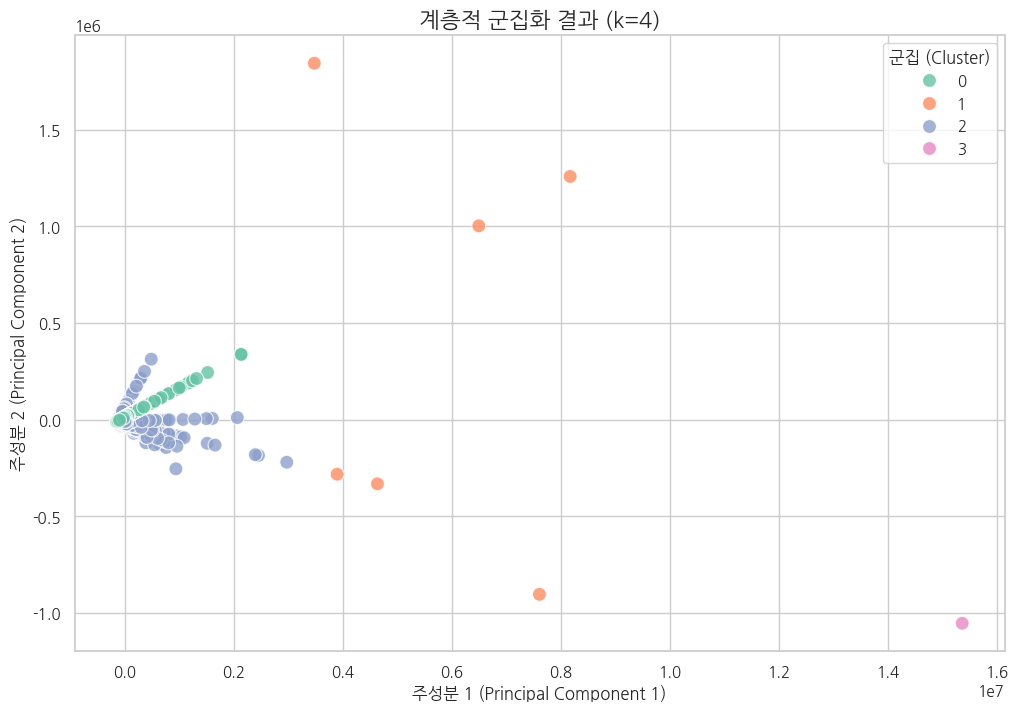

In [109]:
# 군집 결과 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='GMM_CLUSTER', data=pca_df, palette='Set2', s=100, alpha=0.8)
plt.title(f'계층적 군집화 결과 (k=4)', fontsize=16)
plt.xlabel('주성분 1 (Principal Component 1)', fontsize=12)
plt.ylabel('주성분 2 (Principal Component 2)', fontsize=12)
plt.legend(title='군집 (Cluster)')
plt.grid(True)
plt.show()

In [110]:
# PCA 결과에 대한 실루엣 스코어 출력
sil_score = silhouette_score(
    X=pca_df[['PC1', 'PC2']],
    labels=travel['GMM_CLUSTER']
)
sil_score

0.12628901778077534

In [111]:
# numeric_features = [
#     'activity_payment_sum', 'activity_payment_count', 'activity_store_count',
#     'activity_history_rows', 'activity_type_unique', 'lodging_payment_sum',
#     'lodging_payment_count', 'lodging_store_count', 'visit_trip_days',
#     'visit_move_cnt', 'AGE_GRP', 'FAMILY_MEMB', 'INCOME',
#     'HOUSE_INCOME', 'TRAVEL_TERM', 'TRAVEL_NUM', 'TRAVEL_COMPANIONS_NUM'
# ]

# cluster_numeric_summary = travel.groupby('GMM_CLUSTER')[numeric_features].mean()

# print(cluster_numeric_summary.T)

In [112]:
# # 분석용 범주형 피처 목록
# categorical_features = [
#     'TRAVEL_STATUS_ACCOMPANY_CODE', 'MVMN_NM_CODE', 'GENDER_CODE',
#     'TRAVEL_STATUS_RESIDENCE_CODE', 'TRAVEL_STATUS_DESTINATION_CODE'
# ]

# # K-Means 군집별 범주형 피처 최빈값
# cluster_categorical_summary = travel.groupby('GMM_CLUSTER')[categorical_features].agg(lambda x: x.mode()[0])

# print(cluster_categorical_summary)


In [113]:
# # 각 군집의 분포 확인용 출력
# for feature in categorical_features:
#     print(f'--- {feature} 분포 ---')
#     print(travel.groupby('GMM_CLUSTER')[feature].value_counts())
#     print()


## IS_FAILED_TRIP 그룹별 K-Means, 실루엣, 분포 분석

- IS_FAILED_TRIP=0(성공), 1(실패) 각각에 대해 K-Means 수행


In [114]:
travel_grouped = pd.read_csv(DATA_PATH)

In [115]:
# Success / Fail 그룹 분리
travel_success = travel_grouped[travel_grouped['IS_FAILED_TRIP']==0]
travel_success = travel_success.drop(columns='TRAVEL_ID', axis=1)
travel_fail = travel_grouped[travel_grouped['IS_FAILED_TRIP']==1]
travel_fail = travel_fail.drop(columns='TRAVEL_ID', axis=1)

### 성공 그룹


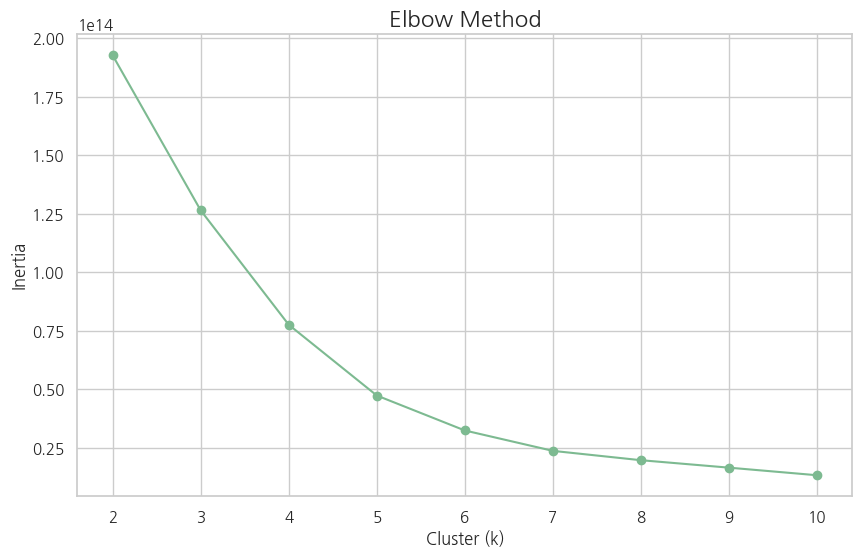

In [116]:
# Elbow method
from sklearn.cluster import KMeans

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X=travel_success[CLUSTERING_FEATURES])
    # kmeans.fit(X=travel_success)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method', fontsize=16)
plt.xlabel('Cluster (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

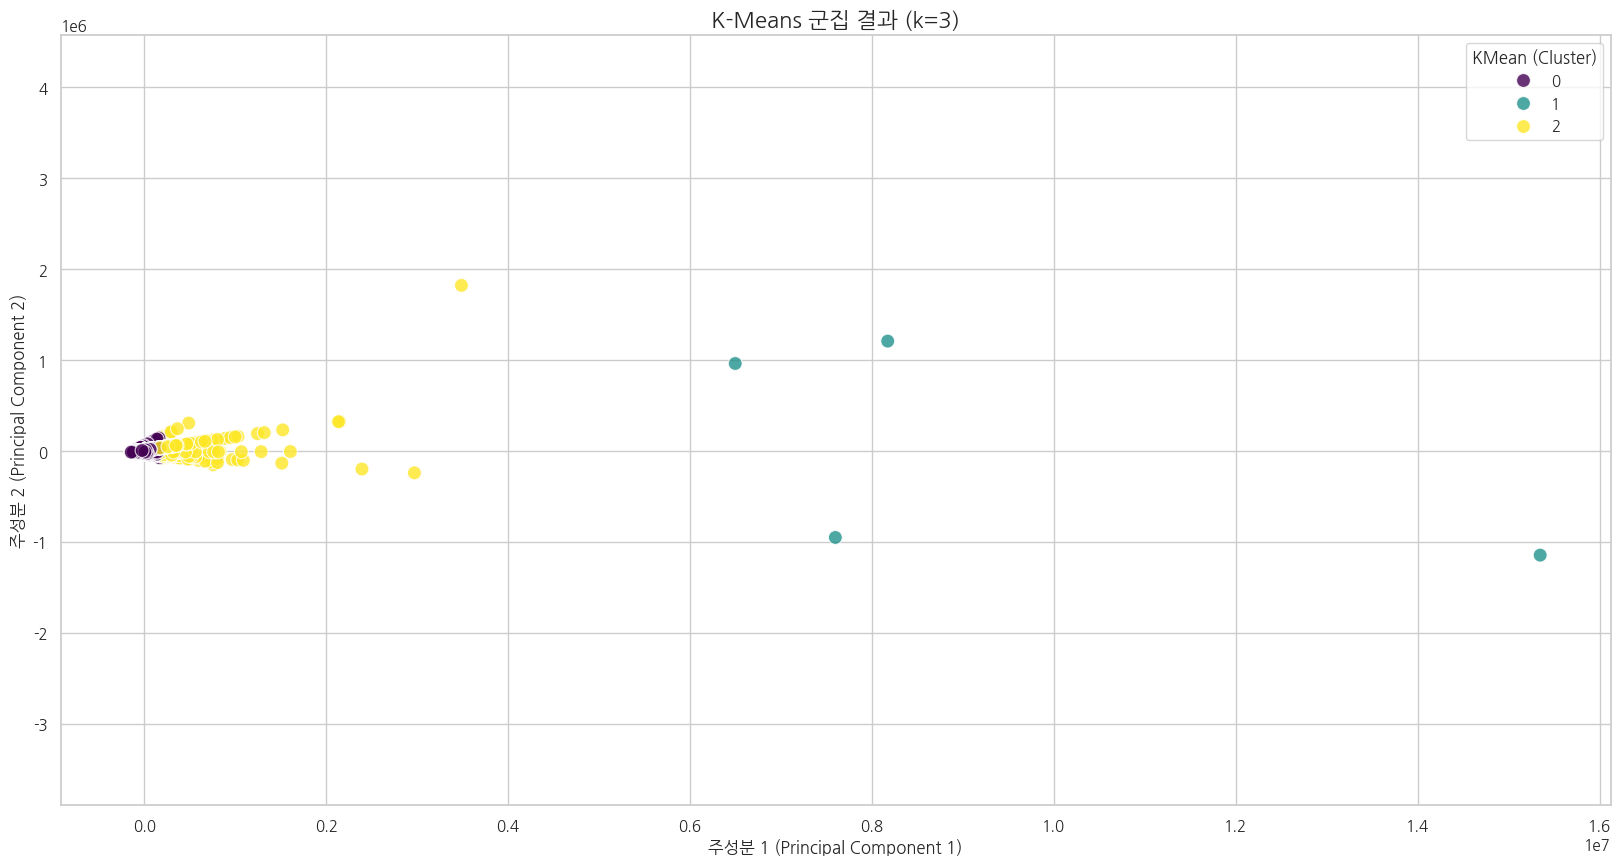

In [117]:
# PCA
from sklearn.decomposition import PCA

# Elbow 결과 기반 k 선택 예시 (여기서는 k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X=travel_success[CLUSTERING_FEATURES])
# cluster_labels = kmeans.fit_predict(X=travel_success)

travel_success.loc[:, 'KMEANS_CLUSTER'] = cluster_labels

pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(X=travel_success[CLUSTERING_FEATURES])
# cluster_pca = pca.fit_transform(X=travel_success)

pca_df = pd.DataFrame(data=cluster_pca, columns=['PC1', 'PC2'])
pca_df['CLUSTER'] = cluster_labels

plt.figure(figsize=(20, 10))
sns.scatterplot(x='PC1', y='PC2', hue='CLUSTER', data=pca_df, palette='viridis', s=100, alpha=0.8)
plt.title(f"K-Means 군집 결과 (k={optimal_k})", fontsize=16)
plt.xlabel("주성분 1 (Principal Component 1)", fontsize=12)
plt.ylabel("주성분 2 (Principal Component 2)", fontsize=12)
plt.axis('equal')
plt.legend(title='KMean (Cluster)')
plt.grid(True)
plt.show()

In [118]:
# 실루엣 스코어 출력 (PCA 시각화와 별개)
sil_score = silhouette_score(
    X=pca_df[['PC1', 'PC2']],
    labels=travel_success['KMEANS_CLUSTER']
)
sil_score

0.7584592177922134

In [119]:
# numeric_features = [
#     'activity_payment_sum', 'activity_payment_count', 'activity_store_count',
#     'activity_history_rows', 'activity_type_unique', 'lodging_payment_sum',
#     'lodging_payment_count', 'lodging_store_count', 'visit_trip_days',
#     'visit_move_cnt', 'AGE_GRP', 'FAMILY_MEMB', 'INCOME',
#     'HOUSE_INCOME', 'TRAVEL_TERM', 'TRAVEL_NUM', 'TRAVEL_COMPANIONS_NUM'
# ]

# cluster_numeric_summary = travel_success.groupby('KMEANS_CLUSTER')[numeric_features].mean()

# print(cluster_numeric_summary.T)

In [120]:
# # 분석용 범주형 피처 목록
# categorical_features = [
#     'TRAVEL_STATUS_ACCOMPANY_CODE', 'MVMN_NM_CODE', 'GENDER_CODE',
#     'TRAVEL_STATUS_RESIDENCE_CODE', 'TRAVEL_STATUS_DESTINATION_CODE'
# ]

# # K-Means 군집별 범주형 피처 최빈값
# cluster_categorical_summary = travel_success.groupby('KMEANS_CLUSTER')[categorical_features].agg(lambda x: x.mode()[0])

# print(cluster_categorical_summary)


In [121]:
# # 각 군집의 분포 확인용 출력
# for feature in categorical_features:
#     print(f'--- {feature} 분포 ---')
#     print(travel_success.groupby('KMEANS_CLUSTER')[feature].value_counts())
#     print()


### 실패 그룹


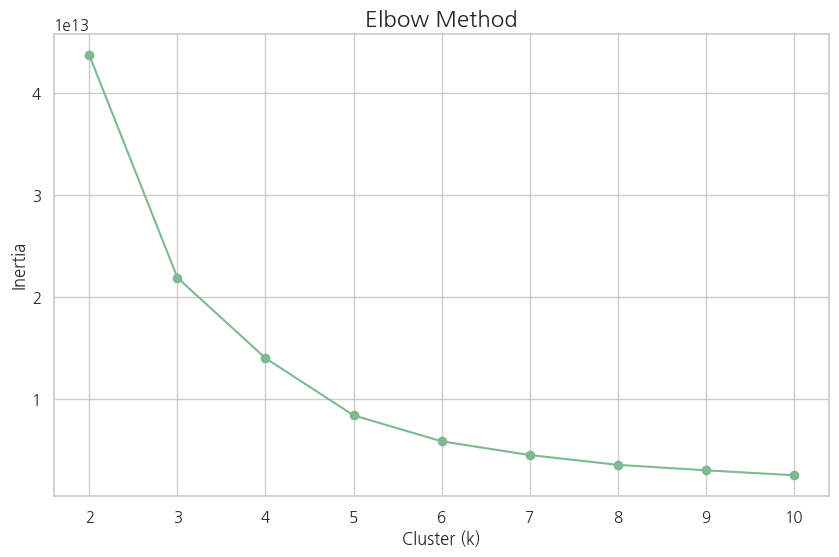

In [122]:
# Elbow method
from sklearn.cluster import KMeans

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X=travel_fail[CLUSTERING_FEATURES])
    # kmeans.fit(X=travel_fail)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method', fontsize=16)
plt.xlabel('Cluster (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

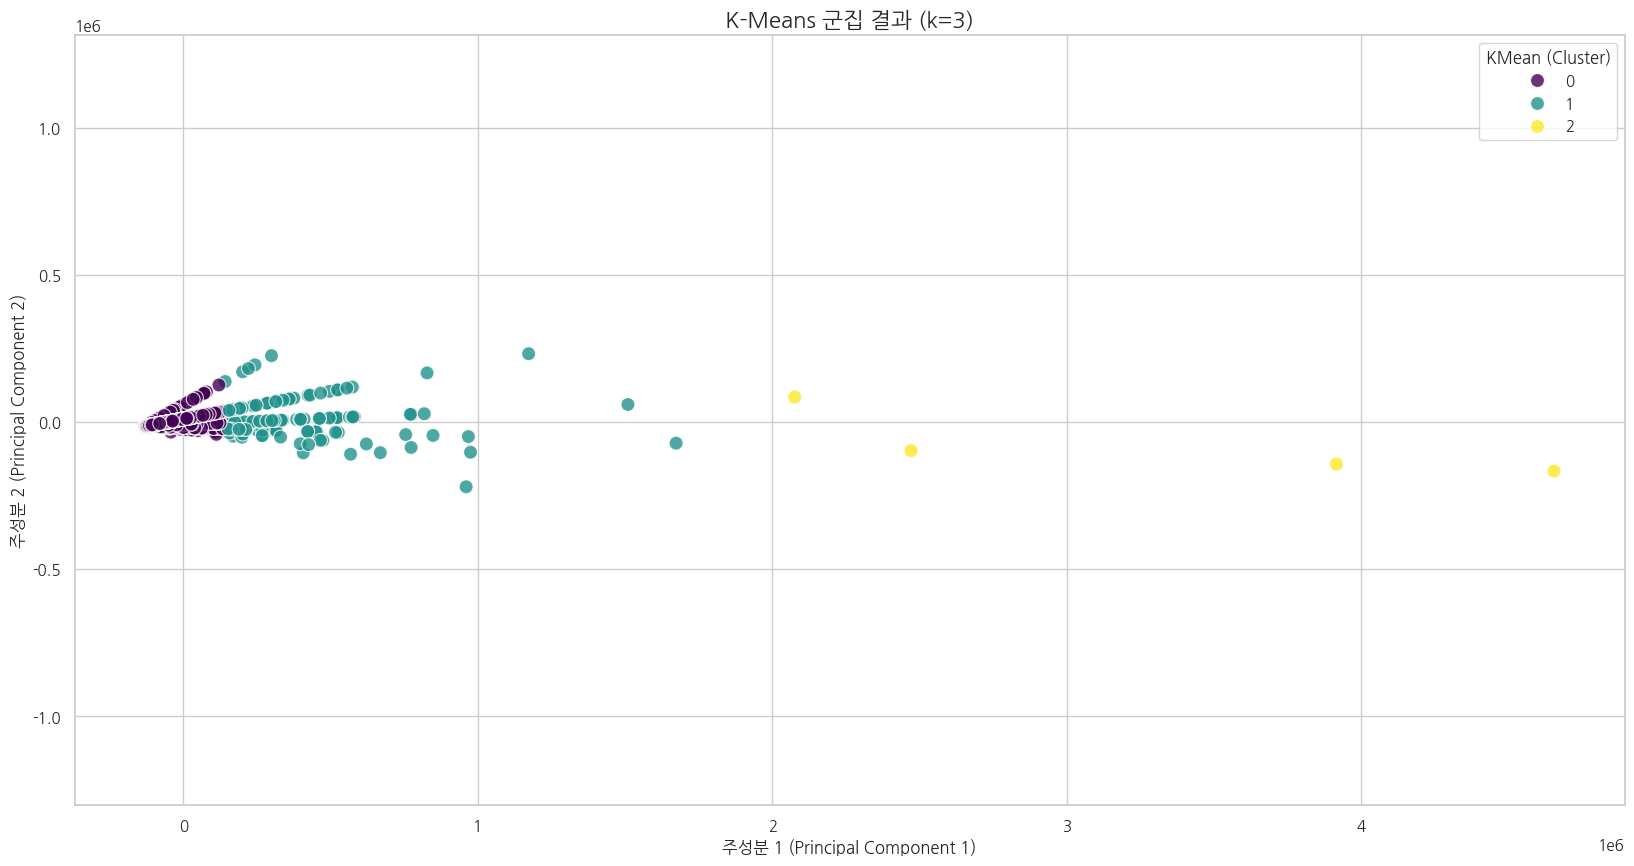

In [123]:
# PCA
from sklearn.decomposition import PCA

# Elbow 결과 기반 k 선택 예시 (여기서는 k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X=travel_fail[CLUSTERING_FEATURES])
# cluster_labels = kmeans.fit_predict(X=travel_fail)

travel_fail.loc[:, 'KMEANS_CLUSTER'] = cluster_labels

pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(X=travel_fail[CLUSTERING_FEATURES])
# cluster_pca = pca.fit_transform(X=travel_fail)

pca_df = pd.DataFrame(data=cluster_pca, columns=['PC1', 'PC2'])
pca_df['CLUSTER'] = cluster_labels

plt.figure(figsize=(20, 10))
sns.scatterplot(x='PC1', y='PC2', hue='CLUSTER', data=pca_df, palette='viridis', s=100, alpha=0.8)
plt.title(f"K-Means 군집 결과 (k={optimal_k})", fontsize=16)
plt.xlabel("주성분 1 (Principal Component 1)", fontsize=12)
plt.ylabel("주성분 2 (Principal Component 2)", fontsize=12)
plt.axis('equal')
plt.legend(title='KMean (Cluster)')
plt.grid(True)
plt.show()

In [124]:
# 실루엣 스코어 출력 (PCA 시각화와 별개)
sil_score = silhouette_score(
    X=pca_df[['PC1', 'PC2']],
    labels=travel_fail['KMEANS_CLUSTER']
)
sil_score

0.7471827212435659

In [125]:
# numeric_features = [
#     'activity_payment_sum', 'activity_payment_count', 'activity_store_count',
#     'activity_history_rows', 'activity_type_unique', 'lodging_payment_sum',
#     'lodging_payment_count', 'lodging_store_count', 'visit_trip_days',
#     'visit_move_cnt', 'AGE_GRP', 'FAMILY_MEMB', 'INCOME',
#     'HOUSE_INCOME', 'TRAVEL_TERM', 'TRAVEL_NUM', 'TRAVEL_COMPANIONS_NUM'
# ]

# cluster_numeric_summary = travel_fail.groupby('KMEANS_CLUSTER')[numeric_features].mean()

# print(cluster_numeric_summary.T)

In [126]:
# # 분석용 범주형 피처 목록
# categorical_features = [
#     'TRAVEL_STATUS_ACCOMPANY_CODE', 'MVMN_NM_CODE', 'GENDER_CODE',
#     'TRAVEL_STATUS_RESIDENCE_CODE', 'TRAVEL_STATUS_DESTINATION_CODE'
# ]

# # K-Means 군집별 범주형 피처 최빈값
# cluster_categorical_summary = travel_fail.groupby('KMEANS_CLUSTER')[categorical_features].agg(lambda x: x.mode()[0])

# print(cluster_categorical_summary)


In [127]:
# # 각 군집의 분포 확인용 출력
# for feature in categorical_features:
#     print(f'--- {feature} 분포 ---')
#     print(travel_fail.groupby('KMEANS_CLUSTER')[feature].value_counts())
#     print()


# Success vs. Fail


In [128]:
# --- 데이터 준비---

# 1. 성공 그룹에 대한 K-Means 및 PCA 수행
kmeans_success = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_success = kmeans_success.fit_predict(travel_success[CLUSTERING_FEATURES])
# labels_success = kmeans_success.fit_predict(travel_success)
pca_success = PCA(n_components=2)
pca_result_success = pca_success.fit_transform(travel_success[CLUSTERING_FEATURES])
# pca_result_success = pca_success.fit_transform(travel_success)
pca_success_df = pd.DataFrame(data=pca_result_success, columns=['PC1', 'PC2'])
pca_success_df['CLUSTER'] = labels_success

# 2. 실패 그룹에 대한 K-Means 및 PCA 수행
kmeans_fail = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_fail = kmeans_fail.fit_predict(travel_fail[CLUSTERING_FEATURES])
# labels_fail = kmeans_fail.fit_predict(travel_fail)
pca_fail = PCA(n_components=2)
pca_result_fail = pca_fail.fit_transform(travel_fail[CLUSTERING_FEATURES])
# pca_result_fail = pca_fail.fit_transform(travel_fail)
pca_fail_df = pd.DataFrame(data=pca_result_fail, columns=['PC1', 'PC2'])
pca_fail_df['CLUSTER'] = labels_fail

optimal_k = 3

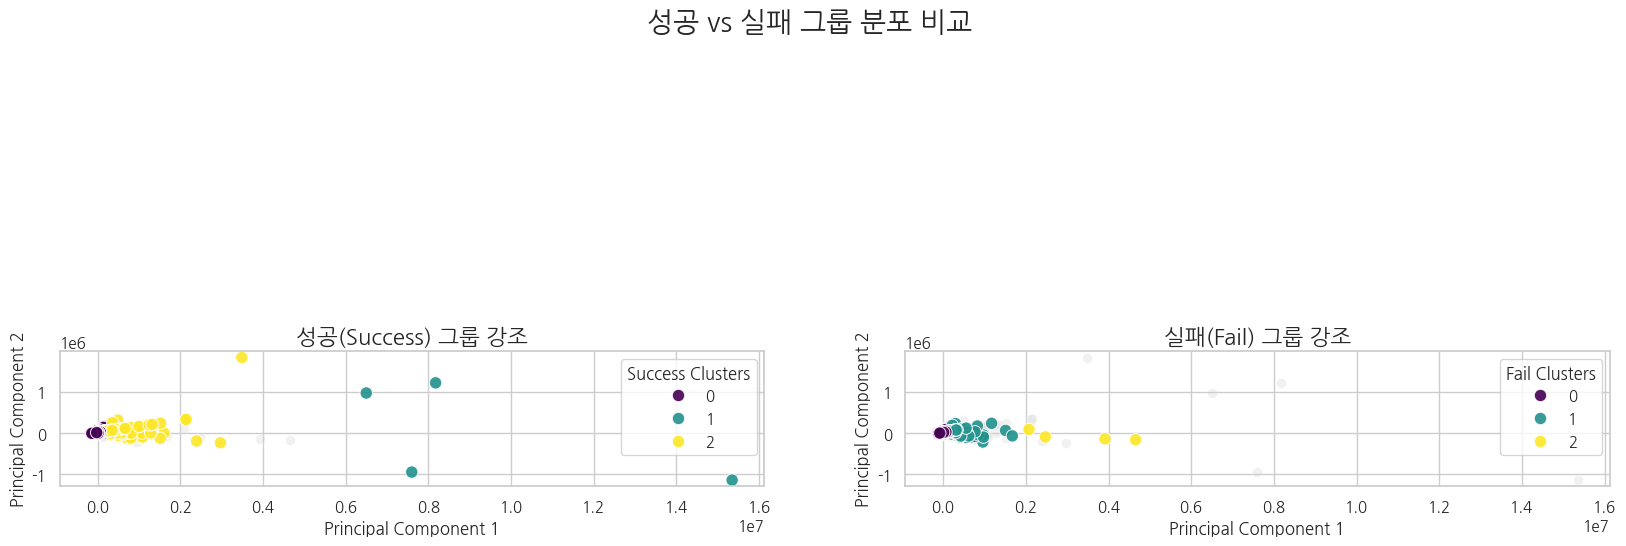

In [129]:
# --- 동일한 스케일로 겹쳐서 시각화 ---

# 1. 1행 2열의 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
fig.patch.set_facecolor('white') # 그림 전체 배경을 흰색으로

# 2. 왼쪽 플롯: 성공(Success) 그룹 강조
# 배경 (실패 그룹)을 연한 회색으로 먼저 그립니다.
sns.scatterplot(data=pca_fail_df, x='PC1', y='PC2', color='lightgrey', alpha=0.3, s=50, ax=ax1, legend=False)
# 강조 (성공 그룹)를 진한 색상으로 그 위에 겹쳐 그립니다.
sns.scatterplot(data=pca_success_df, x='PC1', y='PC2', hue='CLUSTER', palette='viridis', s=80, alpha=0.9, ax=ax1)
ax1.set_title('성공(Success) 그룹 강조', fontsize=16)
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.grid(True)
ax1.legend(title='Success Clusters')


# 3. 오른쪽 플롯: 실패(Fail) 그룹 강조
# 배경 (성공 그룹)을 연한 회색으로 먼저 그립니다.
sns.scatterplot(data=pca_success_df, x='PC1', y='PC2', color='lightgrey', alpha=0.3, s=50, ax=ax2, legend=False)
# 강조 (실패 그룹)를 진한 색상으로 그 위에 겹쳐 그립니다.
sns.scatterplot(data=pca_fail_df, x='PC1', y='PC2', hue='CLUSTER', palette='viridis', s=80, alpha=0.9, ax=ax2)
ax2.set_title('실패(Fail) 그룹 강조', fontsize=16)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.grid(True)
ax2.legend(title='Fail Clusters')


# 4. 두 플롯의 전체 축 범위를 계산하여 동일하게 설정 (이전과 동일)
# x_min = min(ax1.get_xlim()[0], ax2.get_xlim()[0])
# x_max = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
# y_min = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
# y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# ax1.set_xlim(x_min, x_max)
# ax1.set_ylim(y_min, y_max)
# ax2.set_xlim(x_min, x_max)
# ax2.set_ylim(y_min, y_max)

ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')


plt.suptitle('성공 vs 실패 그룹 분포 비교', fontsize=20, y=0.95)
plt.show()